## Librerias

In [34]:
# Tratamiento de datos
import pandas as pd
from datetime import datetime
import numpy as np

# NLP
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import spacy
from collections import Counter

# Regex
import re

# Vectorización
from sklearn.feature_extraction.text import CountVectorizer

# Clusterización
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Preporcesado ML
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, RobustScaler

# Warnings
import warnings
warnings.filterwarnings("ignore")

## Carga de datos

In [2]:
df = pd.read_csv("..\\data\\processed\\feature_engeering.csv", index_col=0, parse_dates=["date"])

## Análisis de sentimientos

En este apartado simplemente vamos a realizar las mismas modificaciones y transformaciones que utilizamos en el primer notebook de NLP para así tenerlo en nuestro nuevo DataFrame, y desde ahí proseguir con el trabajo de NLP.

In [3]:
sia = SentimentIntensityAnalyzer()

res = {}

for i, x in df.iterrows():
    des = x["description"]
    repo_name = x["repo_name"]
    res[repo_name] = sia.polarity_scores(des)

vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={"index":"repo_name"})
vaders = vaders.merge(df, how="left")

vaders.head()

,repo_name,neg,neu,pos,compound,date,rank,stars,forks,username,issues,description,days_since_lc,repos_by_user
0,awesome-python,0.0,0.687,0.313,0.6249,2018-12-18,1,58777,11448,3209,439,"A curated list of awesome Python frameworks, l...",5.0,1.0
1,awesome-python,0.0,0.687,0.313,0.6249,2018-12-19,1,58801,11454,3209,439,"A curated list of awesome Python frameworks, l...",6.0,1.0
2,awesome-python,0.0,0.687,0.313,0.6249,2018-12-20,1,58840,11455,3209,439,"A curated list of awesome Python frameworks, l...",0.0,1.0
3,awesome-python,0.0,0.687,0.313,0.6249,2018-12-21,1,58882,11465,3209,440,"A curated list of awesome Python frameworks, l...",1.0,1.0
4,awesome-python,0.0,0.687,0.313,0.6249,2018-12-22,1,58936,11470,3209,439,"A curated list of awesome Python frameworks, l...",2.0,1.0


Eliminamos neg, neu y pos porque como vimos en el anterior notebook de nlp, son colineales con compund que nos aporta información global sobre el sentmiento de la descripción.

In [4]:
vaders.drop(columns=["neg", "neu", "pos"], inplace=True)

vaders.head()

,repo_name,compound,date,rank,stars,forks,username,issues,description,days_since_lc,repos_by_user
0,awesome-python,0.6249,2018-12-18,1,58777,11448,3209,439,"A curated list of awesome Python frameworks, l...",5.0,1.0
1,awesome-python,0.6249,2018-12-19,1,58801,11454,3209,439,"A curated list of awesome Python frameworks, l...",6.0,1.0
2,awesome-python,0.6249,2018-12-20,1,58840,11455,3209,439,"A curated list of awesome Python frameworks, l...",0.0,1.0
3,awesome-python,0.6249,2018-12-21,1,58882,11465,3209,440,"A curated list of awesome Python frameworks, l...",1.0,1.0
4,awesome-python,0.6249,2018-12-22,1,58936,11470,3209,439,"A curated list of awesome Python frameworks, l...",2.0,1.0


In [5]:
df = vaders.copy()

## Limpieza description

Debido a que nltk nos permite realizar el análisis de sentimientos sin limpiar el texto hemos avanzado hasta aquí sin tener que pasar por tal proceso, pero para los siguientes pasos es necesario.

### Signos de puntuación

In [6]:
signos = re.compile("(\.)|(\;)|(\:)|(\!)|(\?)|(\¿)|(\@)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)")

def signs_description(des):
    return signos.sub('', des.lower())

df['description'] = df['description'].apply(signs_description)
df['description'].head()

0    a curated list of awesome python frameworks li...
1    a curated list of awesome python frameworks li...
2    a curated list of awesome python frameworks li...
3    a curated list of awesome python frameworks li...
4    a curated list of awesome python frameworks li...
Name: description, dtype: object

In [7]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"  
                               u"\U0001F680-\U0001F6FF"  
                               u"\U0001F1E0-\U0001F1FF"  
                               u"\U00002500-\U00002BEF"  
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642" 
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text.lower())


df['description'] = df['description'].apply(remove_emojis)
df['description'].head()

0    a curated list of awesome python frameworks li...
1    a curated list of awesome python frameworks li...
2    a curated list of awesome python frameworks li...
3    a curated list of awesome python frameworks li...
4    a curated list of awesome python frameworks li...
Name: description, dtype: object

### Stopwords

In [8]:
stopwords_words = stopwords.words('english')

def remove_stopwords(df):
    return " ".join([word for word in df.split() if word not in stopwords_words])

df['description'] = df['description'].apply(remove_stopwords)
df.head()

,repo_name,compound,date,rank,stars,forks,username,issues,description,days_since_lc,repos_by_user
0,awesome-python,0.6249,2018-12-18,1,58777,11448,3209,439,curated list awesome python frameworks librari...,5.0,1.0
1,awesome-python,0.6249,2018-12-19,1,58801,11454,3209,439,curated list awesome python frameworks librari...,6.0,1.0
2,awesome-python,0.6249,2018-12-20,1,58840,11455,3209,439,curated list awesome python frameworks librari...,0.0,1.0
3,awesome-python,0.6249,2018-12-21,1,58882,11465,3209,440,curated list awesome python frameworks librari...,1.0,1.0
4,awesome-python,0.6249,2018-12-22,1,58936,11470,3209,439,curated list awesome python frameworks librari...,2.0,1.0


## Lemmatización

In [9]:
def word_lemmatizer(x):
    lemmatizer = WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(word) for word in x.split()])

df['description'] = df['description'].apply(word_lemmatizer)
df['description'].head()

0    curated list awesome python framework library ...
1    curated list awesome python framework library ...
2    curated list awesome python framework library ...
3    curated list awesome python framework library ...
4    curated list awesome python framework library ...
Name: description, dtype: object

## Vectorización

In [10]:
vectorizer_c = CountVectorizer()
vectorizer_c.fit(df['description'])

X_baseline_c = vectorizer_c.transform(df['description'])

In [11]:
X_baseline_c.shape

(168687, 6825)

## Clusterización

In [21]:
kmeans_per_k = [MiniBatchKMeans(n_clusters=k, random_state=42).fit(X_baseline_c)
                for k in range(2, 21)]
inertias = [model.inertia_ for model in kmeans_per_k]

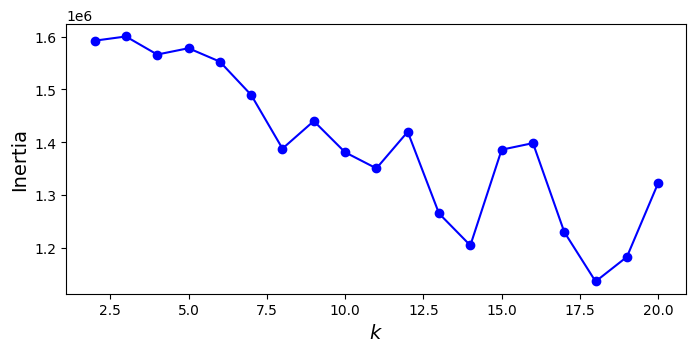

In [23]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(2, 21), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)


plt.show()

In [27]:
silhouette_scores = [silhouette_score(X_baseline_c, model.labels_)
                     for model in kmeans_per_k[2:12]]

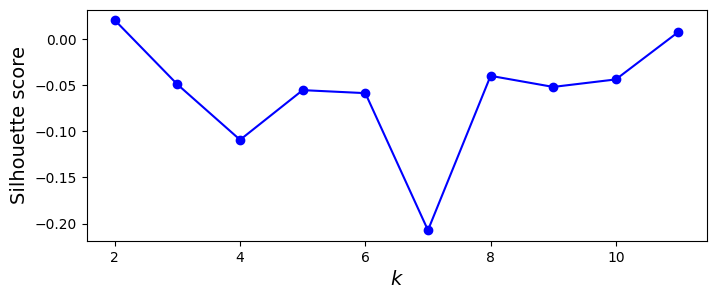

In [28]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 12), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

In [11]:
kmeans = MiniBatchKMeans(8, random_state=42).fit(X_baseline_c)

In [12]:
df['cluster'] = kmeans.labels_
df.head()

,repo_name,compound,date,rank,stars,forks,username,issues,description,days_since_lc,repos_by_user,cluster
0,awesome-python,0.6249,2018-12-18,1,58777,11448,3209,439,curated list awesome python framework library ...,5.0,1.0,4
1,awesome-python,0.6249,2018-12-19,1,58801,11454,3209,439,curated list awesome python framework library ...,6.0,1.0,4
2,awesome-python,0.6249,2018-12-20,1,58840,11455,3209,439,curated list awesome python framework library ...,0.0,1.0,4
3,awesome-python,0.6249,2018-12-21,1,58882,11465,3209,440,curated list awesome python framework library ...,1.0,1.0,4
4,awesome-python,0.6249,2018-12-22,1,58936,11470,3209,439,curated list awesome python framework library ...,2.0,1.0,4


In [13]:
cluster_texts_dict = {i: [] for i in range(8)}
for index, row in df.iterrows():
    cluster_texts_dict[row['cluster']].append(row['description'])

In [14]:
cluster_data = [{'cluster_id': cluster_id, 'text': text} for cluster_id, texts in cluster_texts_dict.items() for text in texts]

In [15]:
cluster_df = pd.DataFrame(cluster_data)

In [16]:
cluster_df.drop_duplicates(inplace=True)

In [17]:
cluster_0 = cluster_df[cluster_df["cluster_id"] == 0]
cluster_1 = cluster_df[cluster_df["cluster_id"] == 1]
cluster_2 = cluster_df[cluster_df["cluster_id"] == 2]
cluster_3 = cluster_df[cluster_df["cluster_id"] == 3]
cluster_4 = cluster_df[cluster_df["cluster_id"] == 4]
cluster_5 = cluster_df[cluster_df["cluster_id"] == 5]
cluster_6 = cluster_df[cluster_df["cluster_id"] == 6]
cluster_7 = cluster_df[cluster_df["cluster_id"] == 7]

### Análisis de los cluster 0

In [18]:
def tokenize_text(text):
    return word_tokenize(text)

cluster_0['tokenized_column'] = cluster_0['text'].apply(tokenize_text)

cluster_0.head()

,cluster_id,text,tokenized_column
0,0,raven legacy python client sentry getsentrycom...,"[raven, legacy, python, client, sentry, getsen..."
2,0,openai python library provides convenient acce...,"[openai, python, library, provides, convenient..."
13,0,python fire library automatically generating c...,"[python, fire, library, automatically, generat..."
1221,0,exploring python counter-intuitive snippet thi...,"[exploring, python, counter-intuitive, snippet..."
1238,0,artistic qr code python animated gif qr code- ...,"[artistic, qr, code, python, animated, gif, qr..."


In [19]:
cluster_0_words = []

for x in cluster_0["tokenized_column"]:
    cluster_0_words.append(x)



In [20]:
concatenated_cluster0 = [item for sublist in cluster_0_words for item in sublist]
concatenated_cluster0

['raven',
 'legacy',
 'python',
 'client',
 'sentry',
 'getsentrycom',
 '—',
 'replaced',
 'sentry-python',
 'openai',
 'python',
 'library',
 'provides',
 'convenient',
 'access',
 'openai',
 'api',
 'application',
 'written',
 'python',
 'language',
 'python',
 'fire',
 'library',
 'automatically',
 'generating',
 'command',
 'line',
 'interface',
 'cli',
 'absolutely',
 'python',
 'object',
 'exploring',
 'python',
 'counter-intuitive',
 'snippet',
 'think',
 'know',
 'python',
 'think',
 'artistic',
 'qr',
 'code',
 'python',
 'animated',
 'gif',
 'qr',
 'code-',
 'python',
 'gif',
 'comprehensive',
 'python',
 'cheatsheet',
 'textual',
 'rapid',
 'application',
 'development',
 'framework',
 'python',
 'build',
 'sophisticated',
 'user',
 'interface',
 'simple',
 'python',
 'api',
 'run',
 'apps',
 'terminal',
 'coming',
 'soon',
 'web',
 'browser',
 'lean',
 'application',
 'framework',
 'python',
 'build',
 'sophisticated',
 'user',
 'interface',
 'simple',
 'python',
 'api',
 '

In [21]:
word_freq = Counter(concatenated_cluster0)

word_freq.most_common(10)

[('python', 79),
 ('library', 7),
 ('framework', 7),
 ('day', 6),
 ('written', 5),
 ('interface', 4),
 ('code', 4),
 ('gif', 4),
 ('simple', 4),
 ('browser', 4)]

### Análisis cluster 1

In [22]:
cluster_1['tokenized_column'] = cluster_1['text'].apply(tokenize_text)

cluster_1_words = []

for x in cluster_1["tokenized_column"]:
    cluster_1_words.append(x)

concatenated_cluster1 = [item for sublist in cluster_1_words for item in sublist]

word_freq = Counter(concatenated_cluster1)

word_freq.most_common(10)

[('python', 824),
 ('learning', 325),
 ('library', 188),
 ('deep', 142),
 ('framework', 126),
 ('machine', 99),
 ('application', 81),
 ('api', 76),
 ('web', 73),
 ('data', 70)]

### Análisis cluster 2

In [23]:
cluster_2['tokenized_column'] = cluster_2['text'].apply(tokenize_text)

cluster_2_words = []

for x in cluster_2["tokenized_column"]:
    cluster_2_words.append(x)

concatenated_cluster2 = [item for sublist in cluster_2_words for item in sublist]

word_freq = Counter(concatenated_cluster2)

word_freq.most_common(10)

[('-', 15),
 ('--', 9),
 ('&', 5),
 ('“', 4),
 ('”', 4),
 ('nlp', 4),
 ('chinese', 2),
 ('//itbert', 1),
 ('coconlpxlorenlucsn', 1),
 ('/+asr', 1)]

### Análisis cluster 3

In [24]:
cluster_3['tokenized_column'] = cluster_3['text'].apply(tokenize_text)

cluster_3_words = []

for x in cluster_3["tokenized_column"]:
    cluster_3_words.append(x)

concatenated_cluster3 = [item for sublist in cluster_3_words for item in sublist]

word_freq = Counter(concatenated_cluster3)

word_freq.most_common(10)

[('web', 22),
 ('django', 20),
 ('change', 20),
 ('free', 19),
 ('detection', 14),
 ('monitor', 13),
 ('website', 12),
 ('apis', 11),
 ('open', 11),
 ('source', 11)]

### Análisis cluster 4

In [47]:
cluster_4['tokenized_column'] = cluster_4['text'].apply(tokenize_text)

cluster_4_words = []

for x in cluster_4["tokenized_column"]:
    cluster_4_words.append(x)

concatenated_cluster4 = [item for sublist in cluster_4_words for item in sublist]

word_freq = Counter(concatenated_cluster4)

word_freq.most_common(10)

[('list', 8),
 ('awesome', 7),
 ('library', 7),
 ('curated', 5),
 ('resource', 5),
 ('framework', 4),
 ('software', 3),
 ('python', 2),
 ('machine', 2),
 ('learning', 2)]

### Análisis cluster 5

In [48]:
cluster_5['tokenized_column'] = cluster_5['text'].apply(tokenize_text)

cluster_5_words = []

for x in cluster_5["tokenized_column"]:
    cluster_5_words.append(x)

concatenated_cluster5 = [item for sublist in cluster_5_words for item in sublist]

word_freq = Counter(concatenated_cluster5)

word_freq.most_common(10)

[('data', 79),
 ('python', 8),
 ('&', 8),
 ('database', 6),
 ('science', 5),
 ('analysis', 5),
 ('structure', 4),
 ('text', 4),
 ('store', 4),
 ('image', 4)]

### Análisis cluster 6

In [56]:
cluster_6['tokenized_column'] = cluster_6['text'].apply(tokenize_text)

cluster_6_words = []

for x in cluster_6["tokenized_column"]:
    cluster_6_words.append(x)

concatenated_cluster6 = [item for sublist in cluster_6_words for item in sublist]

word_freq = Counter(concatenated_cluster6)

word_freq.most_common(10)

[('“', 268),
 ('”', 260),
 ('model', 233),
 ('implementation', 199),
 ('pytorch', 182),
 ('network', 173),
 ('tool', 165),
 ('code', 158),
 ('tensorflow', 152),
 ('image', 135)]

### Análisis cluster 7

In [50]:
cluster_7['tokenized_column'] = cluster_7['text'].apply(tokenize_text)

cluster_7_words = []

for x in cluster_7["tokenized_column"]:
    cluster_7_words.append(x)

concatenated_cluster7 = [item for sublist in cluster_7_words for item in sublist]

word_freq = Counter(concatenated_cluster7)

word_freq.most_common(10)

[('collection', 1), ('design', 1), ('patterns/idioms', 1), ('python', 1)]

## EDA NLP

<Axes: >

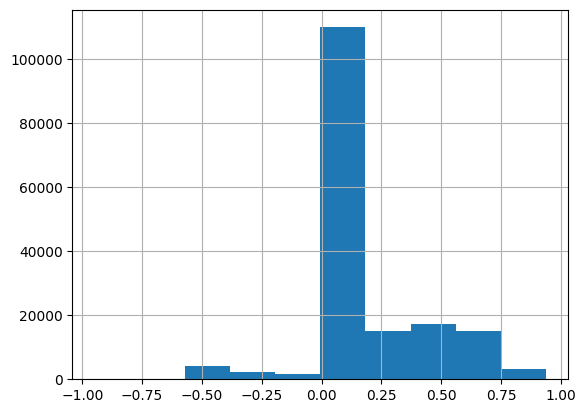

In [62]:
df["compound"].hist()

<Axes: xlabel='cluster', ylabel='Count'>

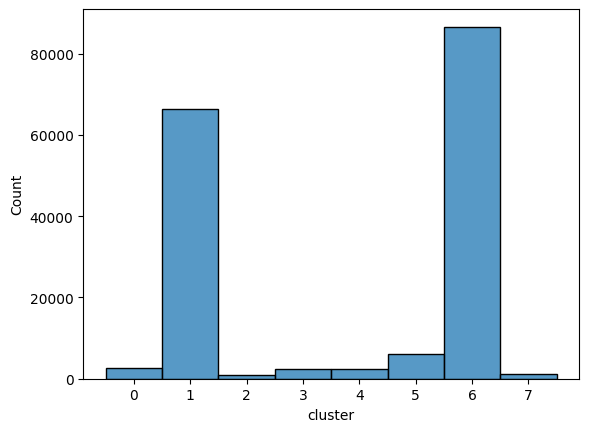

In [63]:
sns.histplot(df, x="cluster", discrete=True)

<Axes: xlabel='compound', ylabel='forks'>

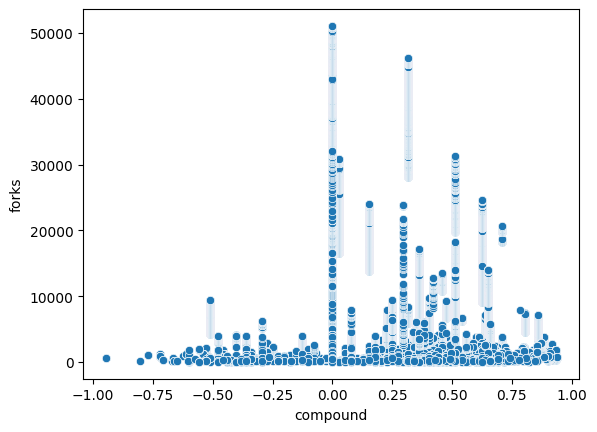

In [74]:
sns.scatterplot(data=df, x="compound", y="forks")

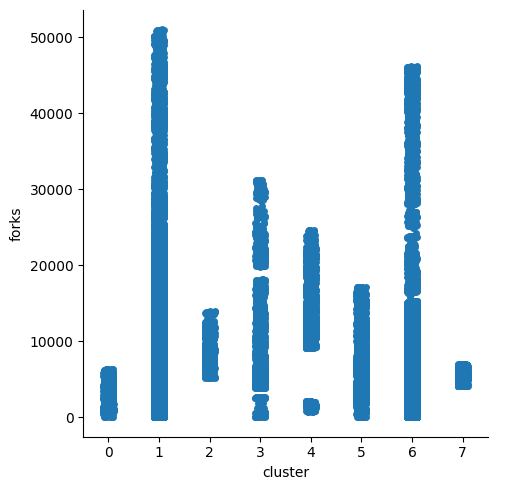

In [66]:
sns.catplot(data=df, x="cluster", y="forks")

<Axes: xlabel='cluster', ylabel='compound'>

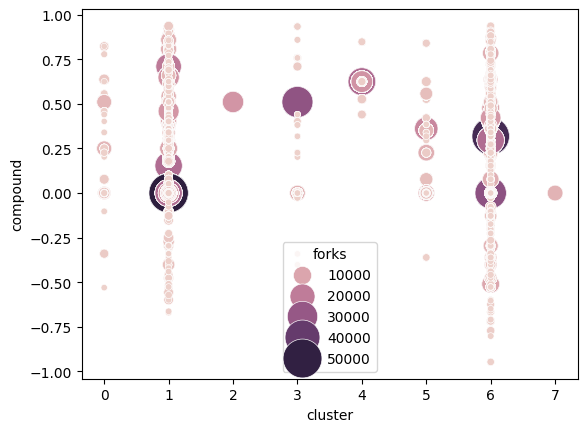

In [33]:
sns.scatterplot(data=df, y="compound", x="cluster", hue="forks", size="forks", sizes=(20, 800))

## Realizando el resto de transformaciones del dataframe

In [35]:
df.columns

Index(['repo_name', 'compound', 'date', 'rank', 'stars', 'forks', 'username',
       'issues', 'description', 'days_since_lc', 'repos_by_user', 'cluster'],
      dtype='object')

In [37]:
df_le = df.drop(columns=["description"])

le = LabelEncoder()
df_le["repo_name"] = le.fit_transform(df_le["repo_name"])

df_le["day"] = df_le["date"].dt.day
df_le["month"] = df_le["date"].dt.month
df_le["year"] = df_le["date"].dt.year
df_le.drop(columns="date", inplace=True)

df_le.head()

,repo_name,compound,rank,stars,forks,username,issues,days_since_lc,repos_by_user,cluster,day,month,year
0,1244,0.6249,1,58777,11448,3209,439,5.0,1.0,4,18,12,2018
1,1244,0.6249,1,58801,11454,3209,439,6.0,1.0,4,19,12,2018
2,1244,0.6249,1,58840,11455,3209,439,0.0,1.0,4,20,12,2018
3,1244,0.6249,1,58882,11465,3209,440,1.0,1.0,4,21,12,2018
4,1244,0.6249,1,58936,11470,3209,439,2.0,1.0,4,22,12,2018


In [38]:
df_le.columns

Index(['repo_name', 'compound', 'rank', 'stars', 'forks', 'username', 'issues',
       'days_since_lc', 'repos_by_user', 'cluster', 'day', 'month', 'year'],
      dtype='object')

In [39]:
RobEsc = RobustScaler()
esc_features = RobEsc.fit_transform(df_le)
df_le[['repo_name', 'compound', 'rank', 'stars', 'forks', 'username', 'issues',
       'days_since_lc', 'repos_by_user', 'cluster', 'day', 'month', 'year']] = esc_features

df_le.head()

,repo_name,compound,rank,stars,forks,username,issues,days_since_lc,repos_by_user,cluster,day,month,year
0,-0.479267,1.963859,-1.0,2.787406,1.826290,0.987031,0.883721,0.111111,0.0,-0.4,0.133333,1.0,-1.5
1,-0.479267,1.963859,-1.0,2.789049,1.827625,0.987031,0.883721,0.166667,0.0,-0.4,0.200000,1.0,-1.5
2,-0.479267,1.963859,-1.0,2.791718,1.827847,0.987031,0.883721,-0.166667,0.0,-0.4,0.266667,1.0,-1.5
3,-0.479267,1.963859,-1.0,2.794593,1.830071,0.987031,0.886628,-0.111111,0.0,-0.4,0.333333,1.0,-1.5
4,-0.479267,1.963859,-1.0,2.798289,1.831183,0.987031,0.883721,-0.055556,0.0,-0.4,0.400000,1.0,-1.5


## Separación de los datos

In [40]:
train, test = train_test_split(df_le, test_size=0.2, random_state=42)

In [41]:
train.to_csv("..\\data\\processed\\train_nlp.csv")
test.to_csv("..\\data\\processed\\test_nlp.csv")